# **The Navier-Stokes equations - ALE**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations using an ALE method, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

The displacement of the circle has been simulated as well as its elongation, resulting in a different behaviour regarding the lift and the drag.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License v2.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time Arbitrary Lagrangian-Eulerian (ALE) finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + ((u-m)\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term. The mesh velocity is denoted by m.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

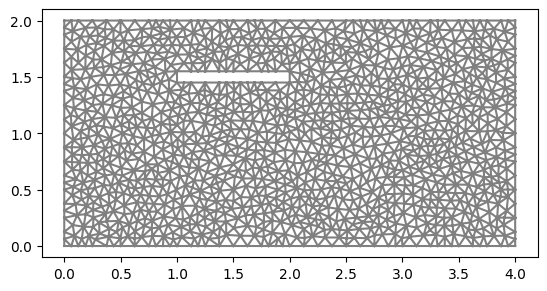

In [ ]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Rectangle(Point(L/2-1,3*H/4-0.05),Point(L/2,3*H/4+0.05)), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [ ]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 0.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [ ]:
# Set viscosity
nu = 4.0e-3

**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Define mesh deformation w, mesh velocity = w/dt
amp_x = 0.0
amp_y = 2e-1
freq = 2
t = 0.0

w = Expression(("0.0","-rc*amp_y*sin(2.0*pi*freq*t+sin(2.0*pi*freq*t))*sin(pi*(x[1])/H)*sin(pi*x[0]/L)"), xc = xc, yc = yc, rc=rc, L=L, H=H, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*(um1-w/dt), v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*(um1-w/dt) + grad(p1), grad(v)*(um1-w/dt))*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*(um1-w/dt) + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [ ]:
# Define the direction of the force to be computed
phi_x_1 = 1.0
phi_y_1 = 0.0
phi_x_2 = 0.0
phi_y_2 = 1.0

def onobject(x):
  return (near(x[0],1) or near(x[0],2)) and (near(x[1],0.9) or near(x[1],1.1))

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_1_expression = Expression(("(near(x[0],1) or near(x[0],2)) and (near(x[1],3*H/4-0.05) or near(x[1],3*H/4+0.05)) ? phi_x : 0.","(near(x[0],1) or near(x[0],2)) and (near(x[1],3*H/4-0.05) or near(x[1],3*H/4+0.05)) ? phi_y : 0."), H=H, xc=xc, yc=yc, rc=rc, phi_x=phi_x_1, phi_y=phi_y_1, element = V.ufl_element())
psi_2_expression = Expression(("(near(x[0],1) or near(x[0],2)) and (near(x[1],3*H/4-0.05) or near(x[1],3*H/4+0.05)) ? phi_x : 0.","(near(x[0],1) or near(x[0],2)) and (near(x[1],3*H/4-0.05) or near(x[1],3*H/4+0.05)) ? phi_y : 0."), H=H, xc=xc, yc=yc, rc=rc, phi_x=phi_x_2, phi_y=phi_y_2, element = V.ufl_element())
psi_1 = interpolate(psi_1_expression, V)
psi_2 = interpolate(psi_2_expression, V)

Force_1 = inner((u1 - u0)/dt + grad(um1)*um1, psi_1)*dx - p1*div(psi_1)*dx + nu*inner(grad(um1), grad(psi_1))*dx
Force_2 = inner((u1 - u0)/dt + grad(um1)*um1, psi_2)*dx - p1*div(psi_2)*dx + nu*inner(grad(um1), grad(psi_2))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS-ALE/u.pvd")
file_p = File("results-NS-ALE/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 200

# Force computation data
force_1_array = np.array(0.0)
force_1_array = np.delete(force_1_array, 0)
force_2_array = np.array(0.0)
force_2_array = np.delete(force_2_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 0.0

**Time stepping algorithm**

In [ ]:
!mkdir results-NS-ALE
!rm results-NS-ALE/*

# Time stepping
T = 20
t = dt
ratio_axes = np.array(1.0)
ratio_axes = np.delete(ratio_axes, 0)

while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    pin.t = t
    #uin.t = t

    w.t = t
    ALE.move(mesh, w)

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F_1 = assemble(Force_1)
        F_2 = assemble(Force_2)
        if (t > start_sample_time):
          force_1_array = np.append(force_1_array, normalization*F_1)
          force_2_array = np.append(force_2_array, normalization*F_2)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plt.figure()
        plot(mesh, title="Mesh")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_1_array)
        plt.plot(time, force_2_array)
        plt.legend(["Drag", "Lift"])
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS-ALE.tar.gz results-NS-ALE
#files.download('results-NS-ALE.tar.gz')

Output hidden; open in https://colab.research.google.com to view.

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D using an ALE finite element method.

# **Moving Cylinder**

![0](https://drive.google.com/uc?export=view&id=1J44GCiiJk-mklTFdiL4l42d4hjdH76cS)

# **Deformation of the cylinder**

In order to deform the cylinder without actually moving it, we want the center of the cylinder not to move, i.e. $w(x_c, y_c) = 0$. That can be achieved by using the following expression for $w$

$$w = \begin{pmatrix}-k_x r_c \sin(2\pi t f)\sin\left(\frac{\pi(x-x_c))}{L}\right)\\
k_y r_c \cos(2\pi t f)\sin\left(\pi\frac{y-y_c}{H}\right)
\end{pmatrix}$$

We use $\nu = 4\times 10^{-3} \iff Re = \frac{UL}{\nu} = \frac{1\times 0.4}{0.4\times 10^{-2}} = 100$. Note that the reynolds changes constantly. Interestingly, depending on $w$, the reynolds can be around $100$ or $20$, implying that (Lab2) the behaviour is different, creating Karman alleys or not.





![1](https://drive.google.com/uc?export=view&id=1Y4Z9huq2YtZxvAEA4Mn48peJRFKVwkVO)
![2](https://drive.google.com/uc?export=view&id=1U14qmz6DyJEFSzWz3R78gc4HulIN2GDH)